# 자전거 쉐어링 수요 예측

# 1. 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘  띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트가 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv('./data/bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape                                       # parse_dates를 이용해 datetime형식으로 불러오기

(10886, 12)

In [4]:
test = pd.read_csv('./data/bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### 데이터 설명

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [7]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [8]:
# null값 있는지 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
# datetime 컬럼 쪼개서 추가로 6개 컬럼 새로 만들기
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [10]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

In [11]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


# 2. EDA

In [12]:
# seaborn, matplotlib 의 이미지에서 한글 표현하기
# 외우지말고 그냥 복붙해서 써도 됨

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
import seaborn as sns

# 이미지에 한글 표시 설정
if platform.system() == 'Windows': # 윈도우인 경우 맑은고딕
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else :  # Mac인 경우 애플고딕
    rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

## 2.1. barplot

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

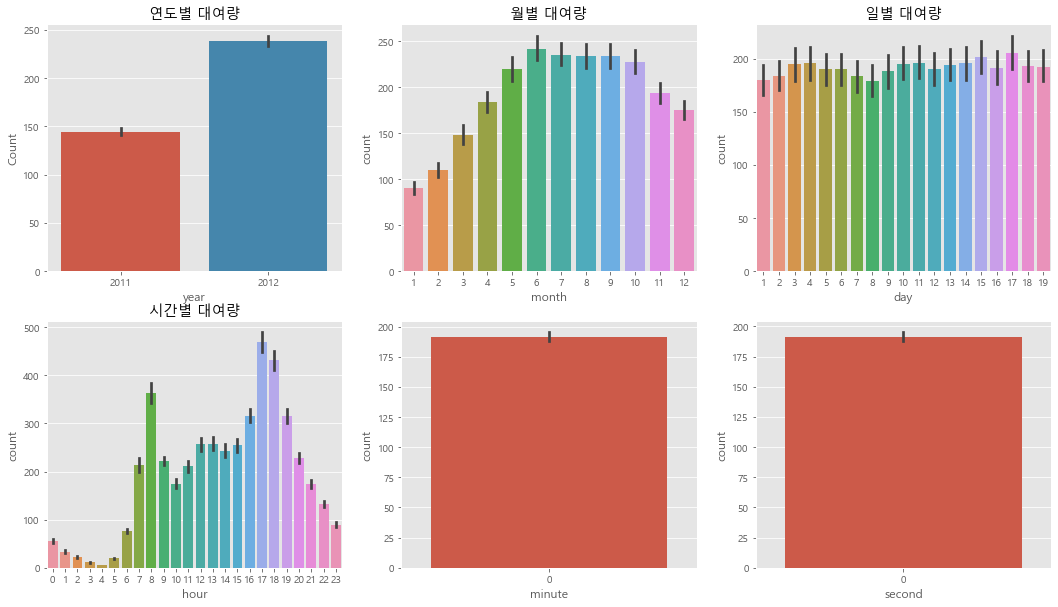

In [13]:
# 각 변수에 알리아스를 지정해서 그래프 그리기
figure, ((ax1,ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,10)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='minute', y='count', ax=ax5)
sns.barplot(data=train, x='second', y='count', ax=ax6)

# 제목 추가
ax1.set(ylabel='Count', title='연도별 대여량')
ax2.set(xlabel='month', title='월별 대여량')
ax3.set(xlabel='day', title='일별 대여량')
ax4.set(xlabel='hour', title='시간별 대여량')

- 연도별 대여량은 2011년보다 2012년이 더 많다.
- 월별 대여량은 5~10월이 많다.
- 일별 대여량은 1~19일만 나타나있고 나머지 데이터는 test.csv에 있기 때문에 피처로 사용할 수 없다.
- 시간별 대여량은 출퇴근 시간이 많다. 그러나 평일과 주말을 구분해서 볼 필요가 있다.
- 분과 초는 다 0으로 나타냈기에 의미가 없다.

## 2.2. boxplot

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

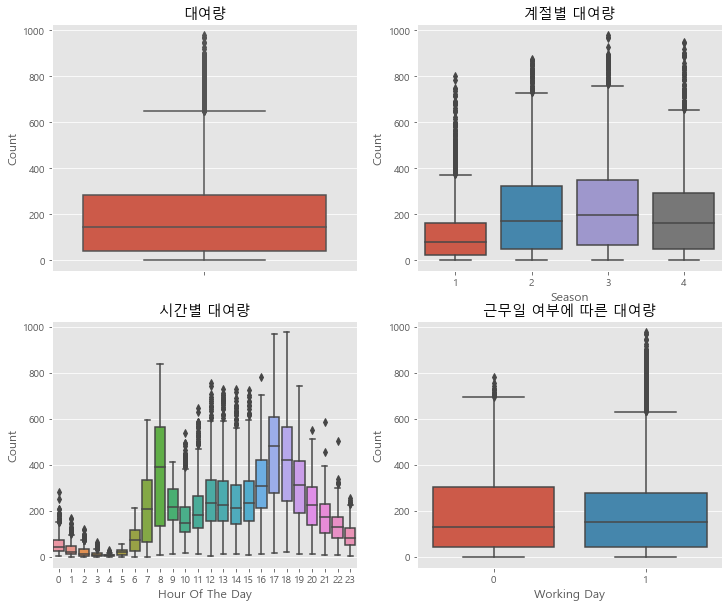

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, y='count', orient='v', x='season', ax=axes[0][1])
sns.boxplot(data=train, y='count', orient='v', x='hour', ax=axes[1][0])
sns.boxplot(data=train, y='count', orient='v', x='workingday', ax=axes[1][1])

# 제목 추가
axes[0][0].set(ylabel='Count', title='대여량')
axes[0][1].set(ylabel='Count', xlabel='Season', title='계절별 대여량')
axes[1][0].set(ylabel='Count', xlabel='Hour Of The Day', title='시간별 대여량')
axes[1][1].set(ylabel='Count', xlabel='Working Day', title='근무일 여부에 따른 대여량')

- 계절별 대여량은 여름과 가을에 많고 봄에는 적다.
- 시간대별 대여량은 barplot에서 본 것과 유사하다.
- 근무 여부에 따른 대여량은 휴일(0)과 평일(1)이 큰 차이는 없지만 휴일이 다소 많다.

## 2.3. pointplot

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '계절별 대여량')]

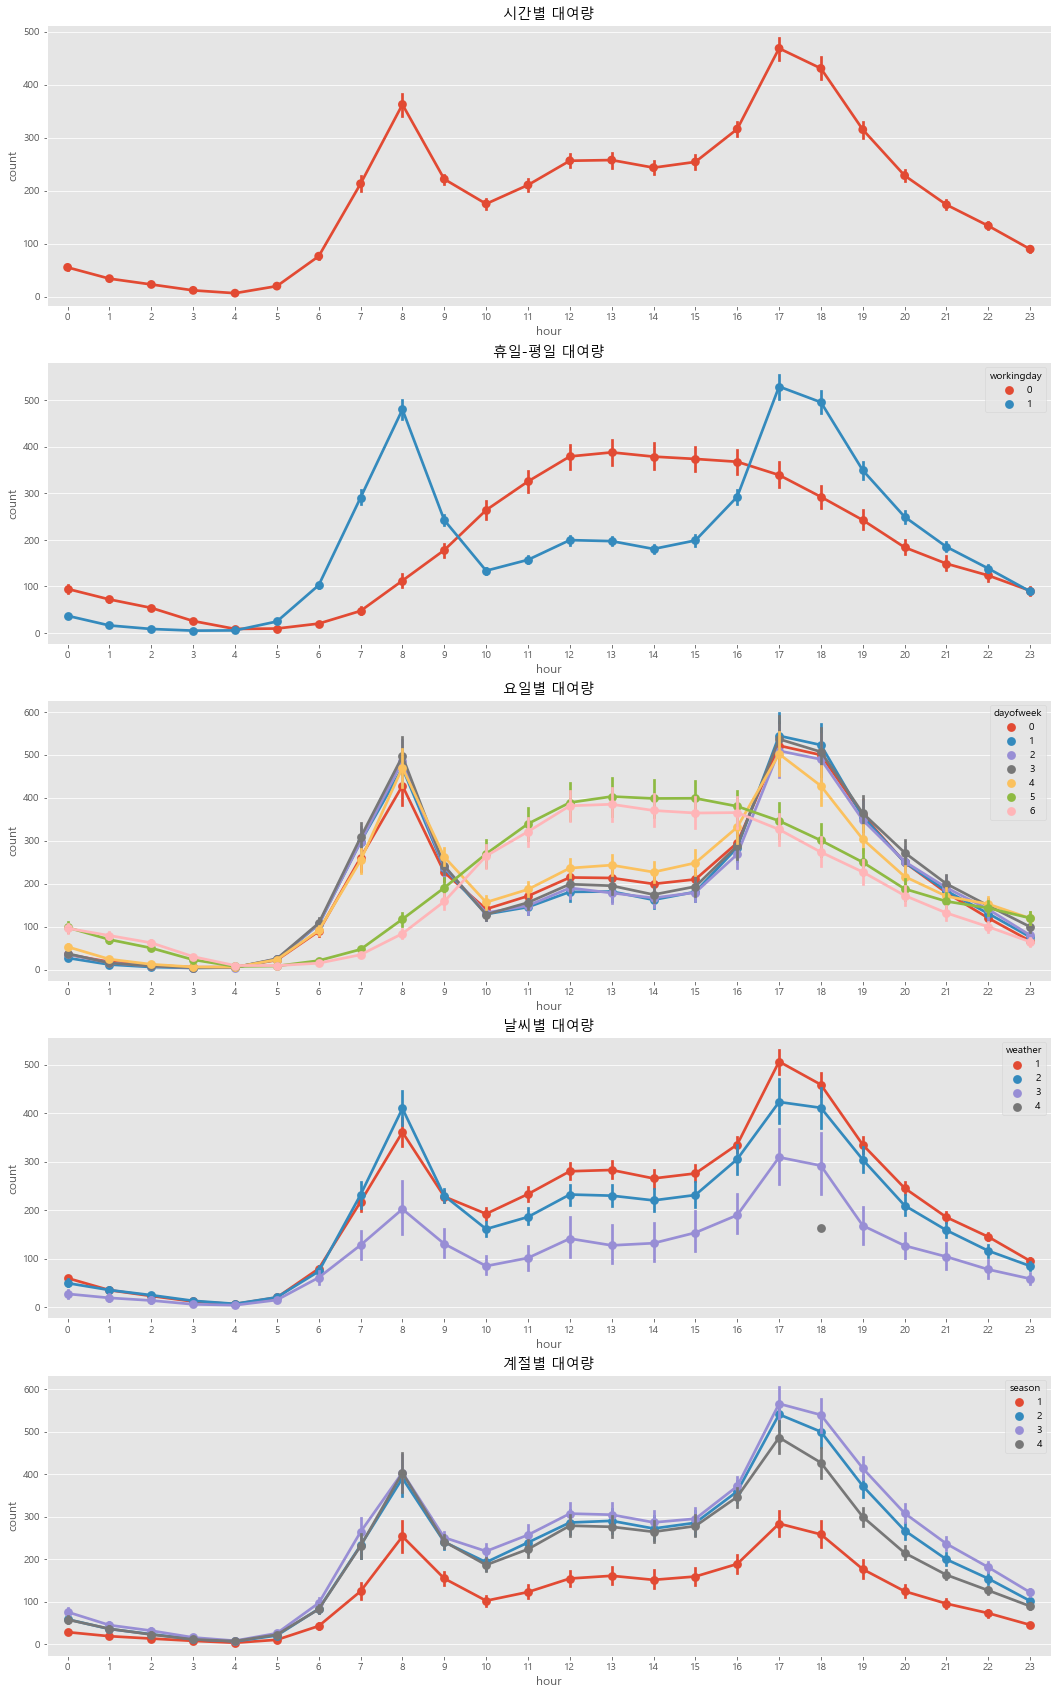

In [15]:
fig, (ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,30)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax5)

ax1.set(xlabel='hour', title='시간별 대여량')
ax2.set(xlabel='hour', title='휴일-평일 대여량')
ax3.set(xlabel='hour', title='요일별 대여량')
ax4.set(xlabel='hour', title='날씨별 대여량')
ax5.set(xlabel='hour', title='계절별 대여량')

- 평일(1)엔 출퇴근 시간에 대여량이 높지만, 휴일(0)엔 11~16시에 높다.
- 요일별 대여량도 위와 결과가 유사하다.
- 날씨별 대여량은 날씨가 좋을 때(1) 대여량이 높다.
- 계절별 대여량은 봄(1)이 가장 적고, 가을(3)이 가장 많다.

## 2.4. heatmap으로 상관계수 확인

In [16]:
# 상관계수 확인(히트맵 활용)
corrMatt = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

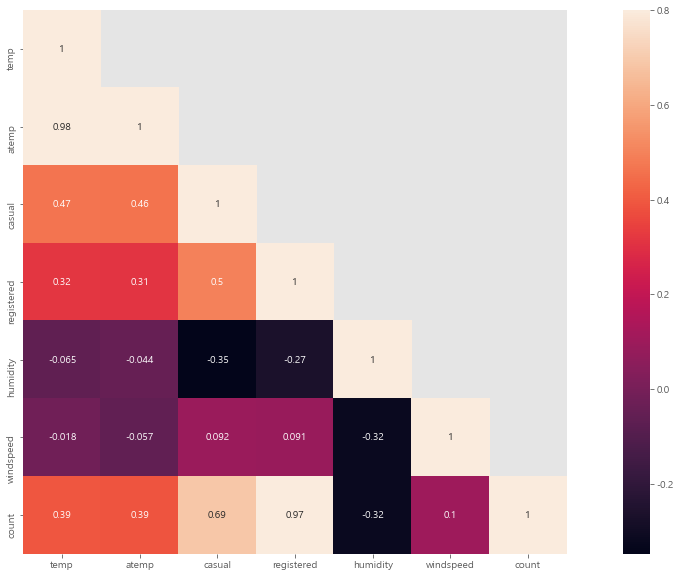

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

- temp, humidity, windspeed는 전체적으로 상관계수가 낮다.
- count(대여량)과 상관계수가 높은건 reistered(등록된 사용자)다.
- 그런데 reistered와 casual(비등록 사용자)은 train 데이터에만 있으므로 피처로 부적합하다.
- atemp(체감온도)와 temp(온도)는 서로 상관계수가 높아서 피처로 부적합하다.

## 2.5. regplot

<AxesSubplot:xlabel='humidity', ylabel='count'>

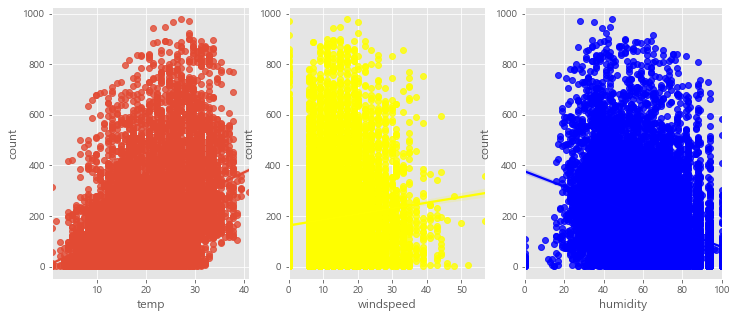

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x='temp', y='count', data=train, ax=ax1)
sns.regplot(x='windspeed', y='count', data=train, ax=ax2, color='yellow')
sns.regplot(x='humidity', y='count', data=train, ax=ax3, color='blue')

- windspeed의 경우 값이 0인 경우가 많은데, 이는 관측되지 않은 데이터로 추측된다.
- 따라서 피처 엔지니어링으로 조정할 필요가 있다.

## 2.6 연도-월별로 보기

In [19]:
def concatenate_year_month(datetime):
    return '{0}-{1}'.format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime', 'year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

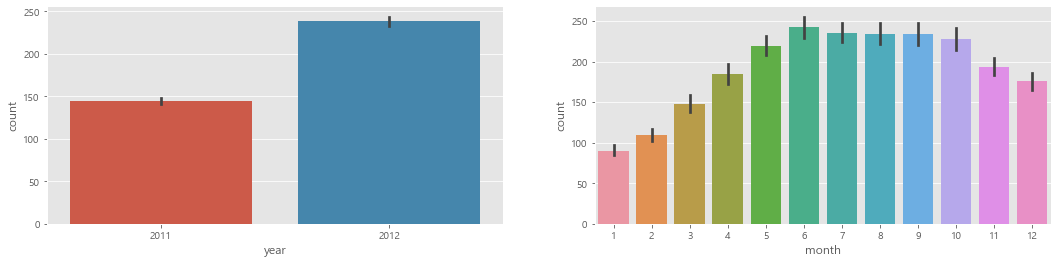

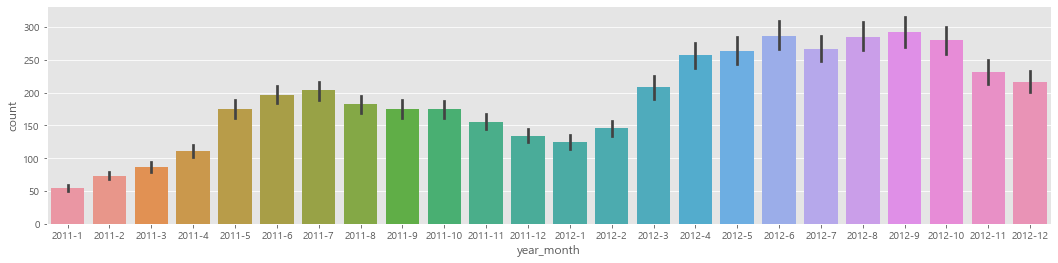

In [20]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)


fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)

마찬가지로 대여량은 2012년에 더 증가했으며 5~8월이 더 높다.

# 3. 이상치 처리

[2.5 regplot]에서 본 것 처럼  windspeed가 0인 경우가 많다. <br>
-> 관측되지 않은 데이터를 다른 값으로 대체해 줄 필요가 있다.

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

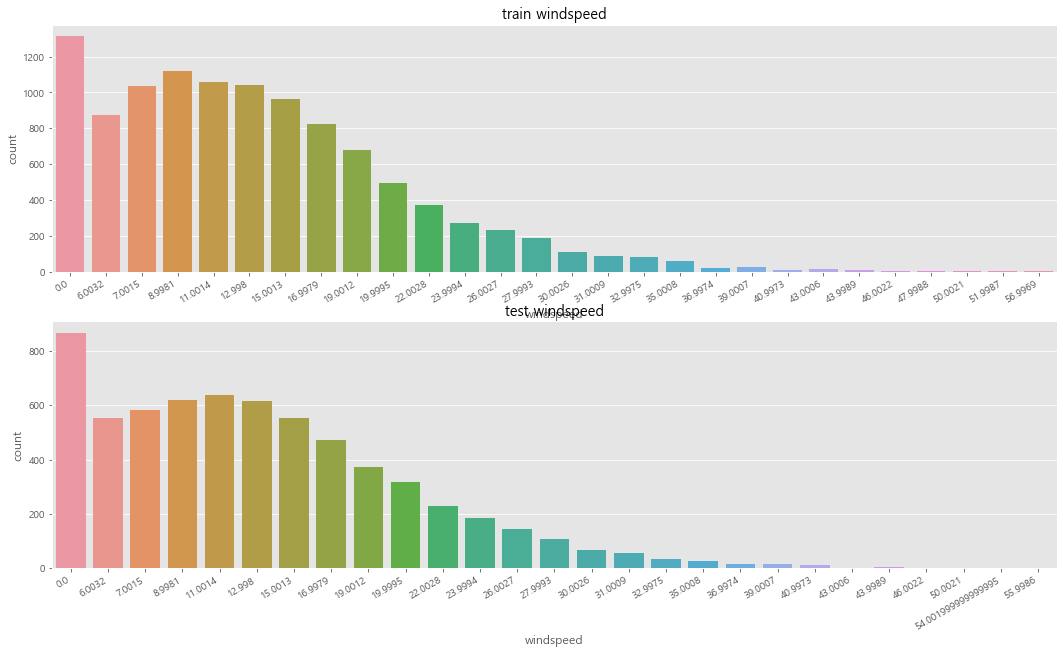

In [21]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

머신러닝으로 예측을 해서 값을 대체하도록 한다!

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
def predict_windspeed(data) :
    
    # 풍속이 0인 것과 아닌 것을 나누어준다.
    dataWind0 = data.loc[data['windspeed'] == 0]  # test 데이터
    dataWindNot0 = data.loc[data['windspeed'] != 0]  # train 데이터
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 값을 다 예측 후 비교해보기 위해 예측한 값을 넣어줄 데이터프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 0으로 기록된 풍속에 예측한 값을 넣어준다.
    predictWind0['windspeed'] = wind0Values
    
    # 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)
    
    # 풍속의 데이터타입을 float으로 지정해준다.
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

<ipython-input-23-488dd3b2923a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
<ipython-input-23-488dd3b2923a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictWind0['windspeed'] = wind0Values


<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

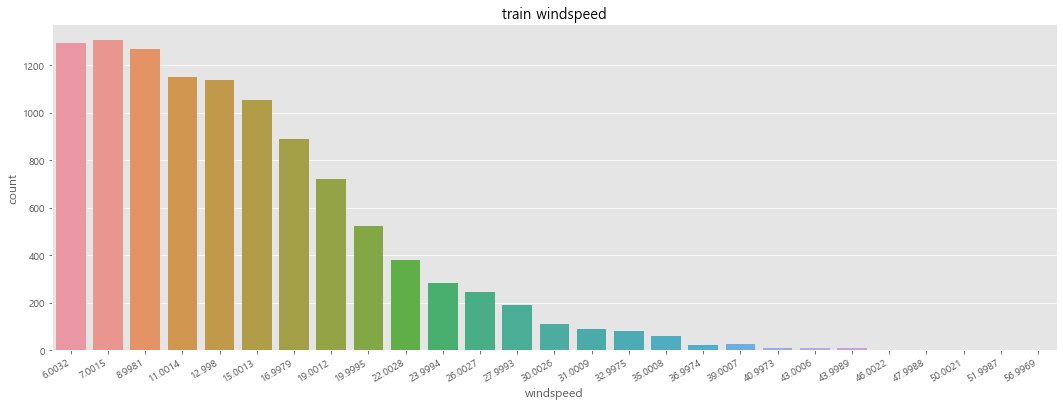

In [24]:
# 0값을 조정한다.
train = predict_windspeed(train)

# windspeed의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

# 4. Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지는 않는다.
- 피처를 하나씩 추가하고 변경해가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [25]:
# 연속형 피처와 범주형 피처
# 연속형 : temp, humidity, windspeed, atemp
# 범주형 : 피처의 타입을 category로 변경해준다.

# 범주형
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather',
                             'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [26]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                 'holiday', 'workingday', 'dayofweek', 'year', 'hour']


In [28]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,holiday,workingday,dayofweek,year,hour
0,1,2,9.84,12.880,75,6.0032,0,0,5,2011,5
1,1,1,15.58,19.695,76,16.9979,0,0,5,2011,10
2,1,1,14.76,16.665,81,19.0012,0,0,5,2011,11
3,1,1,17.22,21.210,77,19.0012,0,0,5,2011,12
4,1,2,18.86,22.725,72,19.9995,0,0,5,2011,13


In [39]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,holiday,workingday,dayofweek,year,hour
0,1,1,10.66,11.365,56,26.0027,0,1,3,2011,0
1,1,1,10.66,13.635,56,0.0000,0,1,3,2011,1
2,1,1,10.66,13.635,56,0.0000,0,1,3,2011,2
3,1,1,10.66,12.880,56,11.0014,0,1,3,2011,3
4,1,1,10.66,12.880,56,11.0014,0,1,3,2011,4


In [40]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# 5. Random Forest

In [41]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [42]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [43]:
# Train 학습
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [44]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.35,   5.08,   4.05,   3.46,   3.06,   6.37,  38.04, 105.91,
       237.35, 136.36])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

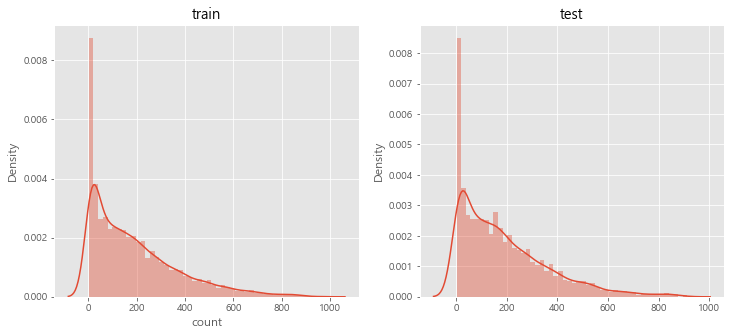

In [46]:
# 시각화
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

# 6. kaggle 제출

In [47]:
# 제공된 sampleSubmission.csv 파일에 예측한 count 값을 넣어준다.
submission = pd.read_csv('./data/bike-sharing-demand/sampleSubmission.csv')
submission

submission['count'] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.35
1,2011-01-20 01:00:00,5.08
2,2011-01-20 02:00:00,4.05
3,2011-01-20 03:00:00,3.46
4,2011-01-20 04:00:00,3.06


In [49]:
submission.to_csv('./data/bike-sharing-demand/mysubmission.csv', index=False)